# 1. Introduction: Synthetic Sonic Curves Generation

## 1.1. Background

Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.

## 1.2. Problem Statement

Compressional travel-time (DTC) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC logs to improve subsurface characterization. The goal of the study is to develop data-driven models by processing “easy-to-acquire” conventional logs from a list of weels, and use the data-driven models to generate synthetic compressional logs (DTC) in rest of Wells. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS logs. The data-driven model should use feature sets derived from the following 8 logs: DEPT, NPHI, RHOB, ILD, CALI, CILD, GR, SP. The data-driven model should synthesize the target logs: DTC.

## 1.3. Data Decription

In [ ]:
las = lasio.read(training_list[]+".las")
for count, curve in enumerate(las.curves):
    print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
print(f"There are a total of: {count+1} curves present within this file")

## 1.4. Evaluation Metric

We will be evaluated by the metirc Root Mean Squared Error.

The RMSE is calculated as:

In [1]:
from IPython.display import Image
Image(filename='RMSE.png')

FileNotFoundError: [Errno 2] No such file or directory: 'RMSE.png'

## Feature Engineering 

- Obter coordenada geográfica de cada local do poço
- Adicionar o nome de cada poço

Where:

- "Fi" is the predicted curve for DTC
- "Oi" is the true value for evaluation.

DTC are in the same weight during the evaluation

Understanding and optimizing your predictions for this evaluation metric is paramount for this chalange.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import lasio
import os
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px

# import sklearn libararies
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# 1.3. Data Decription

In [3]:
%cd "C:\Users\James Bond\Desktop\AI\LP"

#Todos os bancos de dados disponíveis
lasList = pd.DataFrame(os.listdir())[0].tolist()

#Poços a serem pre-processados (Poços com atributos repetidos)
toClean = []

#Dados disponíveis
availebleData = []

#Poços a serem utilizados como treino (Com DT e minemônicos unicos)
training_list = []
training_listName = []

#Poços a serem preditos (Sem DT e minemônicos nulos)
toPredict = []
toPredictName = []

#Seperar os dados a serem pré-processados
for i in range (len(lasList)):
    
    #Ler arquivo las e de seus minemônicos
    las = lasio.read(lasList[i])
    well = (las.df()).reset_index()
    well['LATI'] = las.well.LATI.value
    well['LONG'] = las.well.LONG.value
    
    #Encontrar os dfs com atributos repetidos
    foo = False
    for j in range (len(well.columns)):
        if ":1" in well.columns[j]:
            foo = True
    if foo == True:
        toClean.append(las.well.WELL.value)
    else:
        availebleData.append(las.well.WELL.value)
        
        #Separar os poços com e sem DT
        for s in range(len(well.columns)):
            if well.columns[s] == "DT":
                training_list.append(well)
                training_listName.append(las.well.WELL.value)
            else:
                toPredict.append(well)
                toPredictName.append(las.well.WELL.value)

print("\nIn clonclusion we have:", len(lasList), "Las files in Lagoa Parda, where", len(toClean), "deserve special treatment of the data.","\n\nThere are", len(training_list),
      "files that have the minemonic of interest.")

C:\Users\James Bond\Desktop\AI\LP

In clonclusion we have: 89 Las files in Lagoa Parda, where 31 deserve special treatment of the data. 

There are 7 files that have the minemonic of interest.


In [8]:
minemonicos = ['NPHI', 'RHOB', 'ILD', 'CALI', 'GR', 'SP','DT','DEPT','DRHO']

In [5]:
training_listName

['1-LP-1-ES',
 '3-LP-60-ES',
 '3-LP-61-ES',
 '4-LP-29-ES',
 '4-LP-55-ES',
 '7-LP-39-ES',
 '7-LP-89-ES']

In [6]:
for i in range (len(training_list)):
    count = 0
    for j in range(len(minemonicos)):
        if (minemonicos[j] in training_list[i].columns):
            count = count+1
    if count == 8:
        print(training_listName[i])
        print(training_list[i].columns)

3-LP-60-ES
Index(['DEPT', 'CALI', 'CILD', 'DRHO', 'DT', 'DTL', 'GR', 'ILD', 'NPHI', 'PEF',
       'RHOB', 'SFLU', 'SP', 'TOT', 'TTI', 'LITO', 'LATI', 'LONG'],
      dtype='object')
4-LP-55-ES
Index(['DEPT', 'CALI', 'DRHO', 'DT', 'GR', 'ILD', 'NPHI', 'PEF', 'RHOB',
       'SFLU', 'SP', 'TOT', 'TTI', 'LITO', 'LATI', 'LONG'],
      dtype='object')
7-LP-39-ES
Index(['DEPT', 'CALI', 'CILD', 'DRHO', 'DT', 'EFAC', 'GR', 'ILD', 'NPHI',
       'RHOB', 'RSP', 'SFLU', 'SP', 'TOT', 'TTI', 'VSH', 'LATI', 'LONG'],
      dtype='object')


In [7]:
#Verificar se algum poço possui DT's nulo
for i in range(len(training_list)):
     if training_list[i]['DT'].isnull().any() == False:
        print("Há Sonic nulo")

## Data Cleaning

In [9]:
#Method
trainingWell = pd.concat(training_list)

trainingWell = trainingWell[minemonicos]
trainingWell = trainingWell.dropna()
trainingWell = trainingWell[(trainingWell['DT'] < 150)]
# & (trainingWell['DT'] > 50)

In [10]:
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# labelencoder = LabelEncoder()
# trainingWell.iloc[:, -1] = labelencoder.fit_transform(trainingWell.iloc[:, -1])
# trainingWell.iloc[:, -2] = labelencoder.fit_transform(trainingWell.iloc[:, -2])

## Exploratory Data Analysis

In [ ]:
trainingWell.info()

In [ ]:
trainingWell.describe()

In [ ]:
#Scatterplot matrix
fig = px.scatter_matrix(trainingWell, dimensions=
['NPHI', 'RHOB', 'ILD', 'CALI', 'GR', 'SP','GR'],
labels={col:col.replace('_', ' ') for col in trainingWell.columns},           height=900, color="DEPT", color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

In [ ]:
trainingWell.hist(bins=40, figsize=(20, 15))

## Box Plot

In [ ]:
fig = px.box(trainingWell, x="DT",
color_discrete_sequence=px.colors.qualitative.Dark24,
labels={col:col.replace('_', ' ') for col in trainingWell.columns},
category_orders={})
fig.update_layout(legend=dict(orientation="h", yanchor="bottom",
y=1.02, xanchor="right", x=1))
fig.show()

## Correlation Matrices

In [ ]:
trainingWell.corr()

In [ ]:
import seaborn as sns

corr = trainingWell.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<h1> Build Machine Learning Models

In [11]:
#Definindo Previsores e Classe
x_trainwell1 = trainingWell.loc[:, trainingWell.columns != 'DT'].values
y_trainwell1  = trainingWell.loc[:, trainingWell.columns == 'DT'].values

# standize the matrix for training data
scaler = StandardScaler()
x_trainwell1 = scaler.fit_transform(x_trainwell1)

In [12]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(x_trainwell1, y_trainwell1, test_size=0.2, random_state=100)

X_train.shape, X_test.shape
y_train.shape, y_test.shape

((8927, 1), (2232, 1))

In [13]:
def grid_search(clf, param_grid, X_train=X_train, y_train=y_train):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    # cv uses StratifiedKFold
    # scoring r2 as parameter
    grid = GridSearchCV(estimator=clf, 
                        param_grid=param_grid, 
                        scoring='r2', 
                        cv=5)
    grid.fit(X_train, y_train.ravel())
    print(grid.best_score_)
    
    return grid.best_estimator_

In [14]:
def result_plot(y_predict, y_real=y_trainwell1):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(figsize=(42,12))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:])
    plt.plot(y_predict[:])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:], y_predict[:])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.show()

### Linear Regression AI algorithm

0.9196872559656638
Root Mean Square Error is: 6.01953


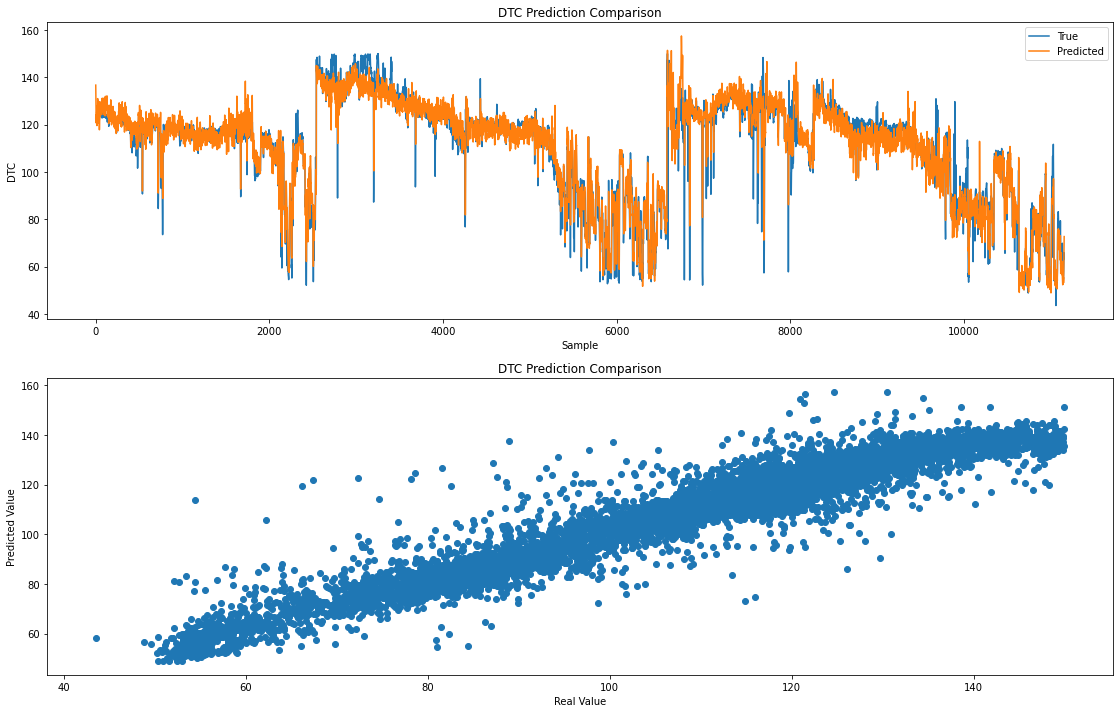

In [15]:
# Linear regression model as the baseline
LR = LinearRegression()
LR_best = grid_search(LR, {})
LR_predict = LR_best.predict(x_trainwell1)
result_plot(LR_predict, y_trainwell1)

### Random forest model

0.9725344559728246
Root Mean Square Error is: 1.81597


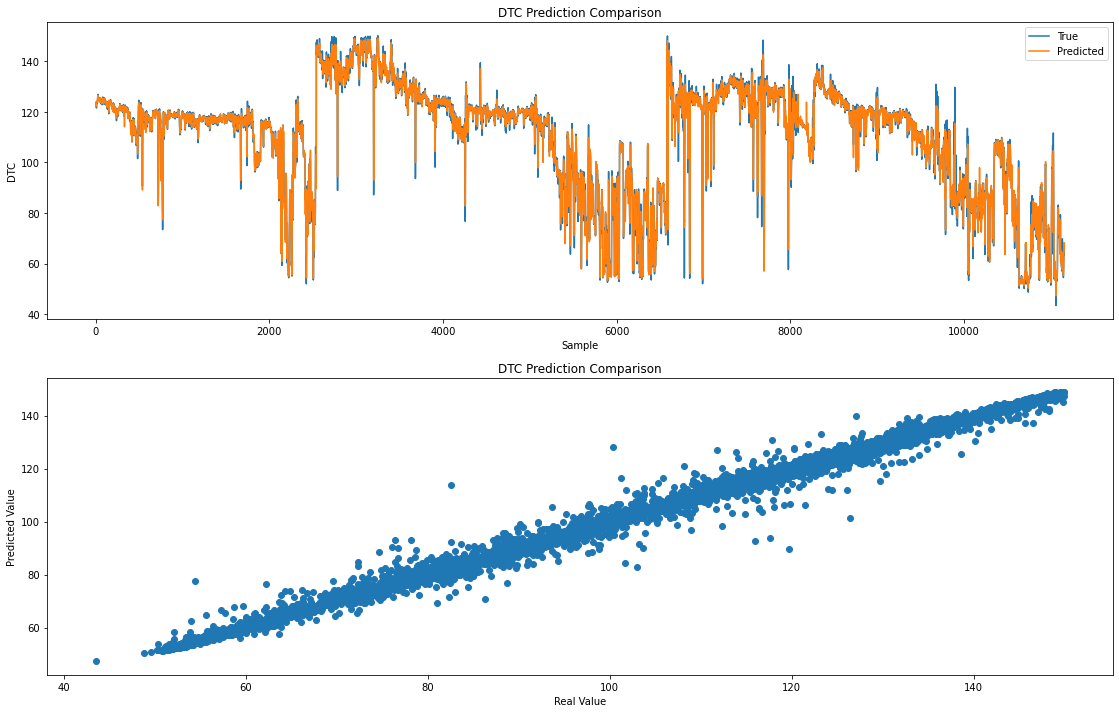

In [16]:
RF = RandomForestRegressor(n_estimators=100, random_state=100)
RF_best = grid_search(RF, {})
result_plot(RF_best.predict(x_trainwell1), y_trainwell1)

## Neural Network - LSTM Model

In [17]:
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import GridSearchCV

# def criarRede(optimizer, loos, kernel_initializer, activation, neurons):
#     classificador = Sequential()
#     classificador.add(Dense(units = neurons, activation = activation, 
#                         kernel_initializer = kernel_initializer, input_dim = 30))
#     classificador.add(Dropout(0.2))
#     classificador.add(Dense(units = neurons, activation = activation, 
#                         kernel_initializer = kernel_initializer))
#     classificador.add(Dropout(0.2))
#     classificador.add(Dense(units = 1, activation = 'sigmoid'))
#     classificador.compile(optimizer = optimizer, loss = loos,
#                       metrics = ['binary_accuracy'])
#     return classificador

# #x_trainwell1=np.reshape(x_trainwell1,(x_trainwell1.shape[0], x_trainwell1.shape[1],1))
# #y_trainwell1=np.reshape(y_trainwell1,(y_trainwell1.shape[0], y_trainwell1.shape[1],1))

# classificador = KerasClassifier(build_fn = criarRede)
# parametros = {'batch_size': [10, 30],
#               'epochs': [50, 100],
#               'optimizer': ['adam', 'sgd'],
#               'loos': ['binary_crossentropy', 'hinge'],
#               'kernel_initializer': ['random_uniform', 'normal'],
#               'activation': ['relu', 'tanh'],
#               'neurons': [16, 8]}
# grid_search = GridSearchCV(estimator = classificador,
#                            param_grid = parametros,
#                            scoring = 'accuracy',
#                            cv = 5)
# grid_search = grid_search.fit(x_trainwell1, y_trainwell1)
# melhores_parametros = grid_search.best_params_
# melhor_precisao = grid_search.best_score_

## Feature Importance

<AxesSubplot:>

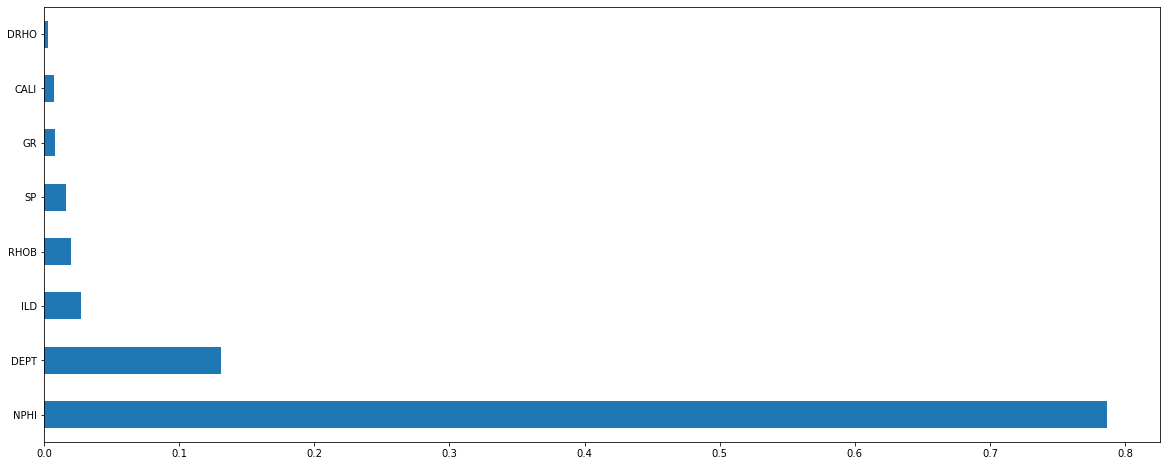

In [18]:
fig, (ax1) = plt.subplots(figsize = (20, 8))
feat_importances = pd.Series(RF_best.feature_importances_, index=trainingWell.loc[:, trainingWell.columns != 'DT'].columns)
feat_importances.nlargest(9).plot(kind='barh')

In [ ]:
# from sklearn.calibration import calibration_curve
# from sklearn.metrics import brier_score_loss

# #Reliability plot and Brier Score
# fig = plt.figure(figsize=(14,10))
# plt.plot([0, 1], [0, 1], color="black")

# #KNN
# knn_y, knn_x = calibration_curve(classe_teste, preds_proba_knn[:,1], n_bins=10, normalize=True)
# loss_knn = brier_score_loss(classe_teste, preds_proba_knn[:,1])
# plt.plot(knn_x, knn_y, marker='o', label=f'KNN, Brier score = {str(round(loss_knn,3))}')

# #Logistic Regression
# lg_y, lg_x = calibration_curve(classe_teste, preds_proba_lg[:,1], n_bins=10, normalize=True)
# loss_lg = brier_score_loss(classe_teste, preds_proba_lg[:,1])
# plt.plot(lg_x, lg_y, marker='o',label=f'Logistic Regression, Brier score = {str(round(loss_lg,3))}')

Once we have the method we can validate its efficiency. For this we must apply the algorithm to a profile that has the same predictors and the "gauge" (DT).

# Metodologia de Aplicação do modelo:
    - 1º Seleciono poço que desejo prever
    - 4º Limpo os dados a serem preditos
    - 3º Crio o modelo com os atributos de todos os poços disponiveis com DT
    - 5º Aplico o modelo no banco selecionado comparando a equação de Faust
    - 6º Visualizo e exporto o banco de dados com Syntetic Sonic

In [19]:
#Leitura do banco de dado de interesse
las2 = lasio.read("7-LP-42-ES.las")
trainingWell2 = (las2.df()).reset_index()
trainingWell2['LATI'] = las.well.LATI.value
trainingWell2['LONG'] = las.well.LONG.value

In [20]:
trainingWell2 = trainingWell2[minemonicos]
trainingWell2 = trainingWell2.dropna()
trainingWell2 = trainingWell2[(trainingWell2['DT'] < 150)]

#Definindo Previsores e Classe
x_trainwell2 = trainingWell2.loc[:, trainingWell2.columns != 'DT'].values
y_trainwell2  = trainingWell2.loc[:, trainingWell2.columns == 'DT'].values

x_trainwell2 = scaler.transform(x_trainwell2)

In [21]:
# run the prediction
well2_predict = RF_best.predict(x_trainwell2)

Root Mean Square Error is: 6.55506


Text(0.5, 1.0, 'DTC Prediction Comparison')

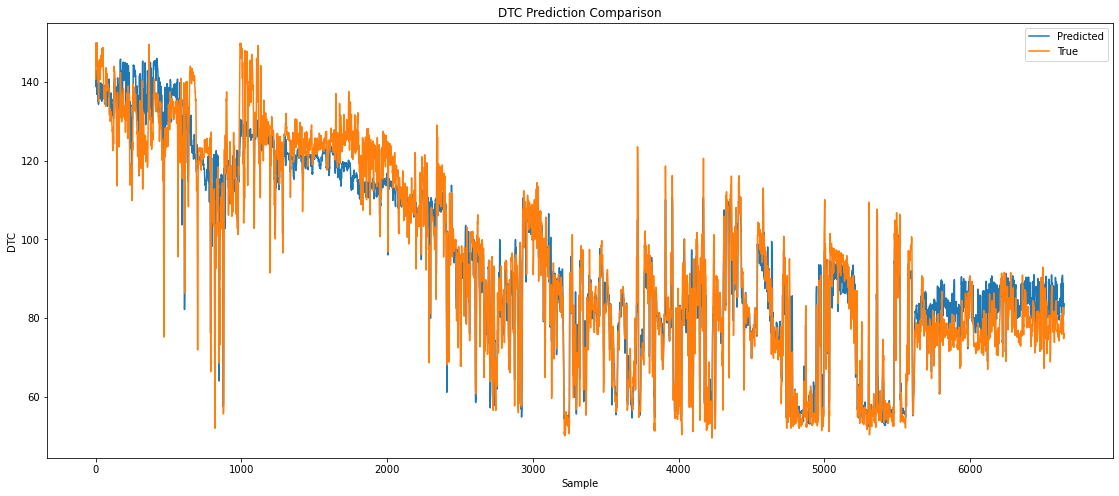

In [24]:
# plot the prediction results
print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(trainingWell2['DT'].values, well2_predict[:]))))

plt.subplots(figsize=(42,8))
plt.subplot(1, 2, 1)
plt.plot(well2_predict[:])
plt.plot(trainingWell2['DT'].values)

plt.legend(['Predicted','True'])
plt.xlabel('Sample')
plt.ylabel('DTC')
plt.title('DTC Prediction Comparison')

In [25]:
#pd.DataFrame(x_trainwell2).head(50)
trainingWell2['SYNTHETIC SONIC'] = well2_predict
trainingWell2.tail()

,NPHI,RHOB,ILD,CALI,GR,SP,DT,DEPT,DRHO,SYNTHETIC SONIC
7141,16.3701,2.4081,1.9100,8.0148,146.3750,-40.1101,74.9411,2427.2,0.0404,81.167394
7142,17.6852,2.4599,1.8579,8.0590,146.2702,-42.3314,74.7940,2427.4,0.1088,82.809787
7143,17.2990,2.4648,1.7647,8.1063,145.5566,-44.5017,75.6851,2427.6,0.1135,82.850100
7144,17.1408,2.4298,1.6919,8.1075,145.6434,-46.9044,76.0855,2427.8,0.0651,83.289494
7145,18.2388,2.4247,1.6565,8.0963,144.5994,-48.5466,75.9439,2428.0,0.0481,83.617778


#### Faust's Equation for DT
$1000 / ((2*DEPT*ILD)^(1/6))$

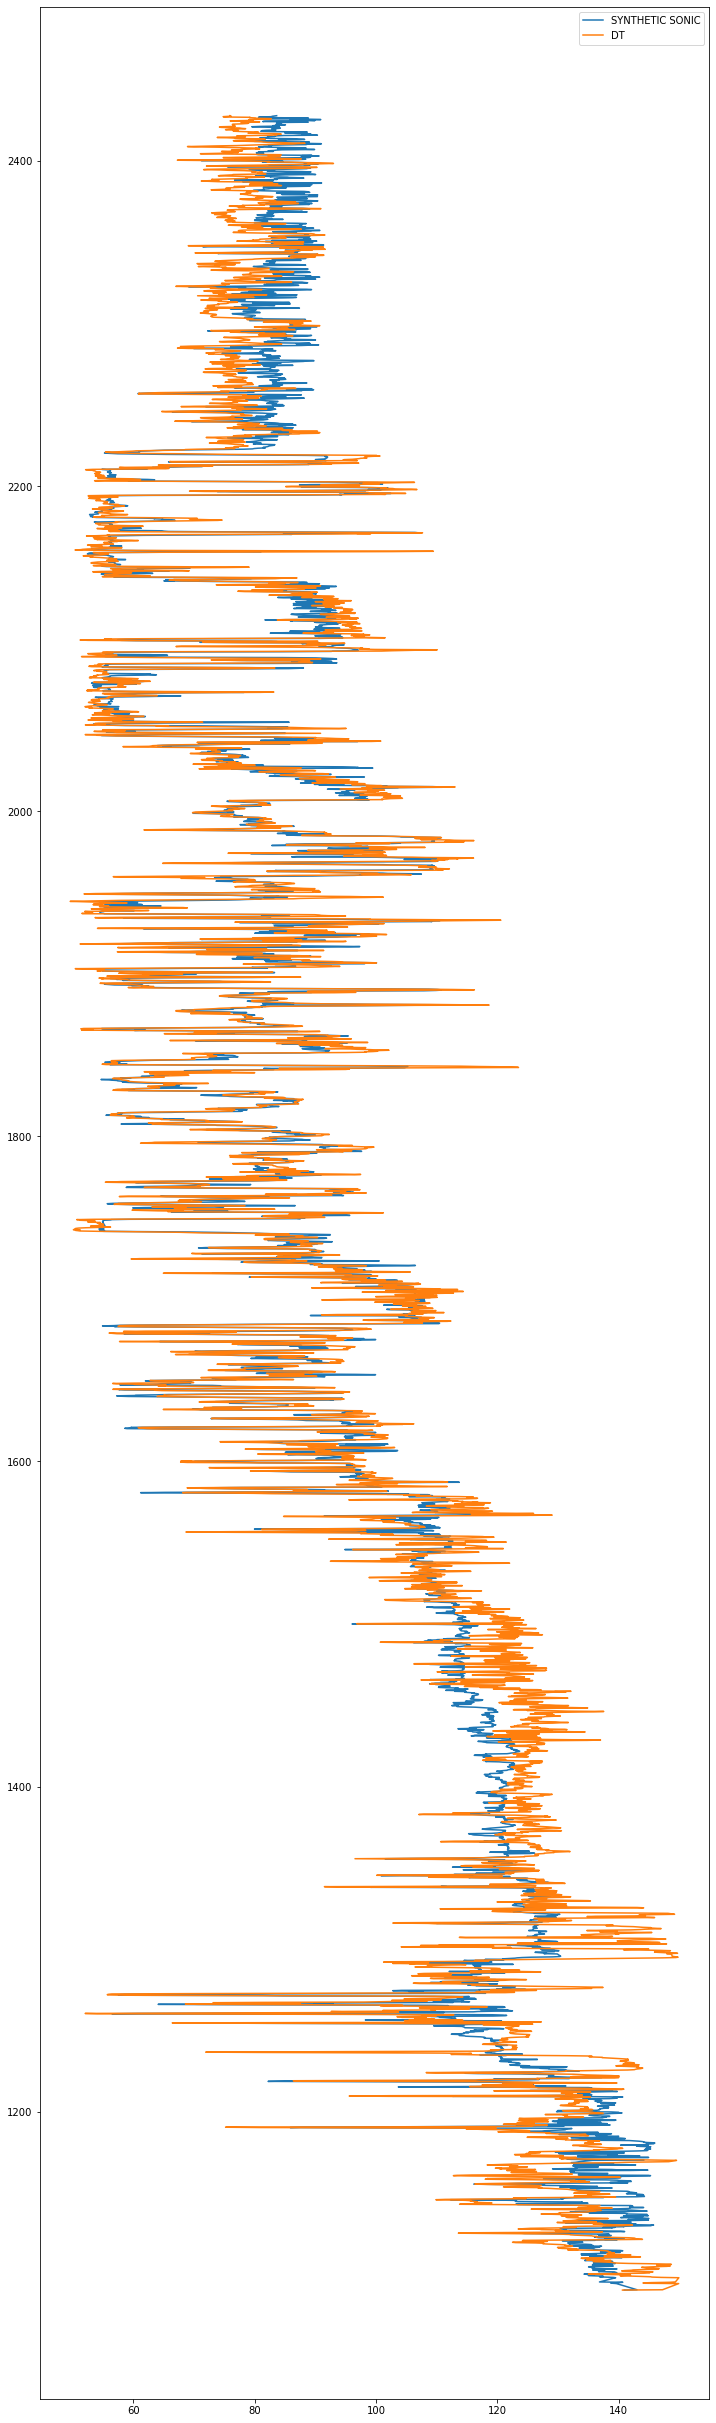

In [31]:
trainingWell2['DT_F'] = 1000/((2*trainingWell2['DEPT']*trainingWell2['ILD'])**(1/3.6))

plt.subplots(figsize=(12,44))

plt.plot(trainingWell2['SYNTHETIC SONIC'],trainingWell2['DEPT'])

plt.plot(trainingWell2['DT'],trainingWell2['DEPT'])

#plt.plot(trainingWell2['DT_F'],trainingWell2['DEPT'])

plt.legend(['SYNTHETIC SONIC','DT'])

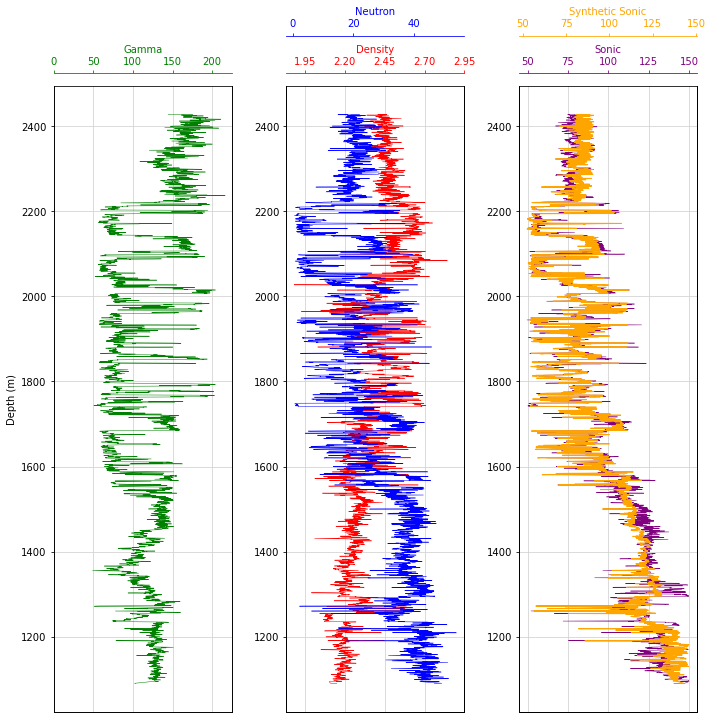

In [34]:
fig, ax = plt.subplots(figsize=(10,10))

#Set up the plot axes
ax1 = plt.subplot2grid((1,3), (0,0), rowspan=1, colspan = 1)
ax2 = plt.subplot2grid((1,3), (0,1), rowspan=1, colspan = 1)
ax3 = plt.subplot2grid((1,3), (0,2), rowspan=1, colspan = 1)
ax4 = ax2.twiny() #Twins the y-axis for the density track with the neutron track
ax5 = ax3.twiny() #Twins the y-axis for the density track with the neutron track

# As our curve scales will be detached from the top of the track,
# this code adds the top border back in without dealing with splines
ax7 = ax1.twiny()
ax7.xaxis.set_visible(False)
ax8 = ax2.twiny()
ax8.xaxis.set_visible(False)
ax9 = ax3.twiny()
ax9.xaxis.set_visible(False)

# Gamma Ray track
ax1.plot("GR", "DEPT", data = trainingWell2, color = "green",linewidth=0.5)
ax1.set_xlabel("Gamma")
ax1.xaxis.label.set_color("green")
ax1.set_ylabel("Depth (m)")
ax1.tick_params(axis='x', colors="green")
ax1.spines["top"].set_edgecolor("green")
ax1.title.set_color('green')
ax1.set_xticks([0, 50, 100, 150, 200])

# Density track
ax2.plot("RHOB", "DEPT", data = trainingWell2, color = "red",linewidth=0.5)
ax2.set_xlabel("Density")
ax2.xaxis.label.set_color("red")
ax2.tick_params(axis='x', colors="red")
ax2.spines["top"].set_edgecolor("red")
ax2.set_xticks([1.95, 2.2, 2.45, 2.7, 2.95])

# Sonic track
ax3.plot("DT", "DEPT", data = trainingWell2, color = "purple",linewidth=0.5)
ax3.set_xlabel("Sonic")
ax3.xaxis.label.set_color("purple")
ax3.tick_params(axis='x', colors="purple")
ax3.spines["top"].set_edgecolor("purple")

# Neutron track placed ontop of density track
ax4.plot("NPHI", "DEPT", data = trainingWell2, color = "blue",linewidth=0.5)
ax4.set_xlabel('Neutron')
ax4.xaxis.label.set_color("blue")
ax4.tick_params(axis='x', colors="blue")
ax4.spines["top"].set_position(("axes", 1.08))
ax4.spines["top"].set_visible(True)
ax4.spines["top"].set_edgecolor("blue")

# Synthetic Sonic - Neural Net AI
ax5.plot("SYNTHETIC SONIC", "DEPT", data = trainingWell2, color = "orange",linewidth=1)
ax5.set_xlabel("Synthetic Sonic")
ax5.xaxis.label.set_color("orange")
ax5.tick_params(axis='x', colors="orange")
ax5.spines["top"].set_position(("axes", 1.08))
ax5.spines["top"].set_visible(True)
ax5.spines["top"].set_edgecolor("orange")

# Synthetic Sonic - Faust's Equsion
# ax5.plot("DT_F", "DEPT", data = trainingWell2, color = "orange",linewidth=1)
# ax5.set_xlabel("Synthetic Sonic")
# ax5.xaxis.label.set_color("orange")
# ax5.tick_params(axis='x', colors="orange")
# ax5.spines["top"].set_position(("axes", 1.08))
# ax5.spines["top"].set_visible(True)
# ax5.spines["top"].set_edgecolor("orange")

# Common functions for setting up the plot can be extracted into
# a for loop. This saves repeating code.
for ax in [ax1, ax2, ax3]:
    #ax.set_ylim(4850, 4600)
    ax.grid(which='major', color='lightgrey')
    ax.xaxis.set_ticks_position("top")
    ax.xaxis.set_label_position("top")
    ax.spines["top"].set_position(("axes", 1.02))
    
    
plt.tight_layout()

In [ ]:
trainingWell2

## References:

https://github.com/pddasig/Machine-Learning-Competition-2020/blob/master/Synthetic%20Sonic%20Log%20Generation%20Starter_Yu%202_27_2020.ipynb
    
https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/14%20-%20Displaying%20Lithology%20Data.ipynb
    
https://github.com/andymcdgeo/Petrophysics-Python-Series/blob/master/05%20-%20Petrophysical%20Calculations.ipynb
    
https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
    
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Competition%20Summay%20-%20Pseudo%20Sonic%20Log%20Generation.pdf